## K2-24 Fitting & MCMC

Using the K2-24 (EPIC-203771098) dataset, we demonstrate how to use the radvel API to:

- perform a max-likelihood fit
- do an MCMC exploration of the posterior space
- plot the results


Perform some preliminary imports:

In [29]:
%matplotlib inline

import os

import matplotlib
import numpy as np
import pylab as pl
import pandas as pd
from scipy import optimize

import corner

import radvel
import radvel.plotting

matplotlib.rcParams['font.size'] = 14

Define a function that we will use to initialize the ``radvel.Parameters`` and ``radvel.RVModel`` objects

In [30]:
def initialize_model():
    time_base = 2420
    params = radvel.Parameters(2,basis='per tc secosw sesinw logk') # number of planets = 2
    params['per1'] = radvel.Parameter(value=20.885258)
    params['tc1'] = radvel.Parameter(value=2072.79438)
    params['secosw1'] = radvel.Parameter(value=0.01)
    params['sesinw1'] = radvel.Parameter(value=0.01)
    params['logk1'] = radvel.Parameter(value=1.1)
    params['per2'] = radvel.Parameter(value=42.363011)
    params['tc2'] = radvel.Parameter(value=2082.62516)
    params['secosw2'] = radvel.Parameter(value=0.01)
    params['sesinw2'] = radvel.Parameter(value=0.01)
    params['logk2'] = radvel.Parameter(value=1.1)
    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = radvel.Parameter(value=-0.02)
    mod.params['curv'] = radvel.Parameter(value=0.01)
    return mod


Define a simple plotting function to display the data, model, and residuals

In [31]:
def plot_results(like):
    fig = pl.figure(figsize=(12,4))
    fig = pl.gcf()
    fig.set_tight_layout(True)
    pl.errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    pl.plot(ti, like.model(ti))
    pl.xlabel('Time')
    pl.ylabel('RV')
    pl.draw()

Load up the K2-24 data. In this example the RV data and parameter starting guesses are stored in an csv file

In [32]:
path = os.path.join(radvel.DATADIR,'epic203771098.csv')
rv = pd.read_csv(path)

t = np.array(rv.t)
vel = np.array(rv.vel)
errvel = rv.errvel
ti = np.linspace(rv.t.iloc[0]-5,rv.t.iloc[-1]+5,100)

### Fit the K2-24 RV data assuming:

1. circular orbits
2. fixed period, time of transit

Set initial guesses for the parameters

In [33]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'].value = 0.1
like.params['jit'].value = 1.0

Choose which parameters to vary or fix. By default, all `radvel.Parameter` objects will vary, so you only have to worry about setting the ones you want to hold fixed.

In [34]:
like.params['secosw1'].vary = False
like.params['sesinw1'].vary = False
like.params['secosw2'].vary = False
like.params['sesinw2'].vary = False
like.params['per1'].vary = False
like.params['per2'].vary = False
like.params['tc1'].vary = False
like.params['tc2'].vary = False
print(like)

parameter                     value      vary
per1                        20.8853      False
tc1                         2072.79      False
secosw1                        0.01      False
sesinw1                        0.01      False
logk1                           1.1       True
per2                         42.363      False
tc2                         2082.63      False
secosw2                        0.01      False
sesinw2                        0.01      False
logk2                           1.1       True
dvdt                          -0.02       True
curv                           0.01       True
jit                               1       True
gamma                             1       True



Plot the initial model

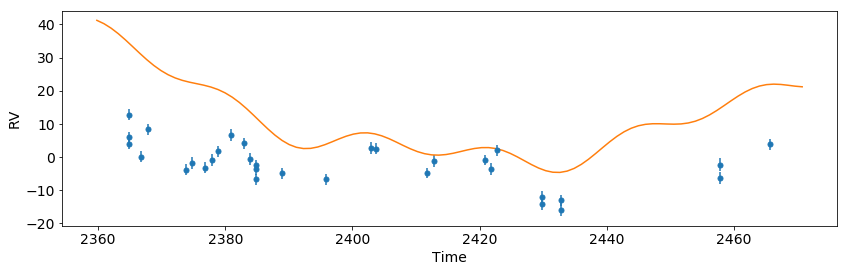

In [35]:
pl.figure()
plot_results(like)

Well that solution doesn't look very good. Now lets try to optimize the parameters set to vary by maximizing the likelihood.

Initialize a ``radvel.Posterior`` object and add some priors

In [36]:
post = radvel.posterior.Posterior(like)
post.priors += [radvel.prior.Gaussian( 'jit', np.log(3), 0.5)]
post.priors += [radvel.prior.Gaussian( 'logk2', np.log(5), 10)]
post.priors += [radvel.prior.Gaussian( 'logk1', np.log(5), 10)]
post.priors += [radvel.prior.Gaussian( 'gamma', 0, 10)]

Maximize the likelihood and print the updated posterior object

parameter                     value      vary
per1                        20.8853      False
tc1                         2072.79      False
secosw1                        0.01      False
sesinw1                        0.01      False
logk1                       1.56037       True
per2                         42.363      False
tc2                         2082.63      False
secosw2                        0.01      False
sesinw2                        0.01      False
logk2                       1.80937       True
dvdt                     -0.0364432       True
curv                    -0.00182455       True
jit                         2.62376       True
gamma                       2.62376       True

Priors
------
Gaussian prior on jit, mu=1.09861228867, sigma=0.5
Gaussian prior on logk2, mu=1.60943791243, sigma=10
Gaussian prior on logk1, mu=1.60943791243, sigma=10
Gaussian prior on gamma, mu=0, sigma=10



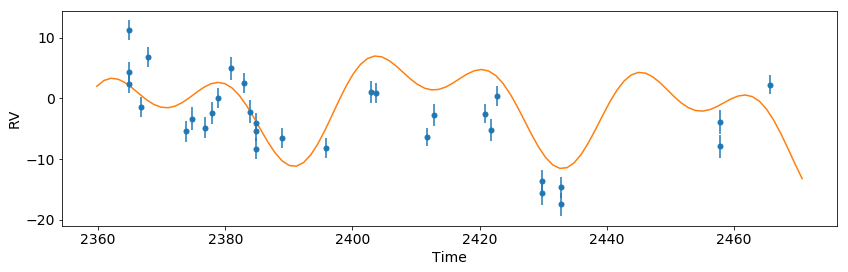

In [37]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )

plot_results(like)             # plot best fit model
print(post)

That looks much better!

Now lets use Markov-Chain Monte Carlo (MCMC) to estimate the parameter uncertainties.
In this example we will run 1000 steps for the sake of speed but in practice you should let it run at least 10000 steps and ~50 walkers. If the chains converge before they reach the maximum number of allowed steps it will automatically stop.

In [38]:
df = radvel.mcmc(post,nwalkers=20,nrun=1000)

8000/160000 (5.0%) steps complete; Running 6969.56 steps/s; Mean acceptance rate = 53.5%; Min Tz = 2241.8; Max G-R = 1.01      
Discarding burn-in now that the chains are marginally well-mixed

160000/160000 (100.0%) steps complete; Running 8206.64 steps/s; Mean acceptance rate = 51.7%; Min Tz = 1069.4; Max G-R = 1.03      

MCMC: WARNING: chains did not pass convergence tests. They are likely not well-mixed.


Now lets make a corner plot to display the posterior distributions.

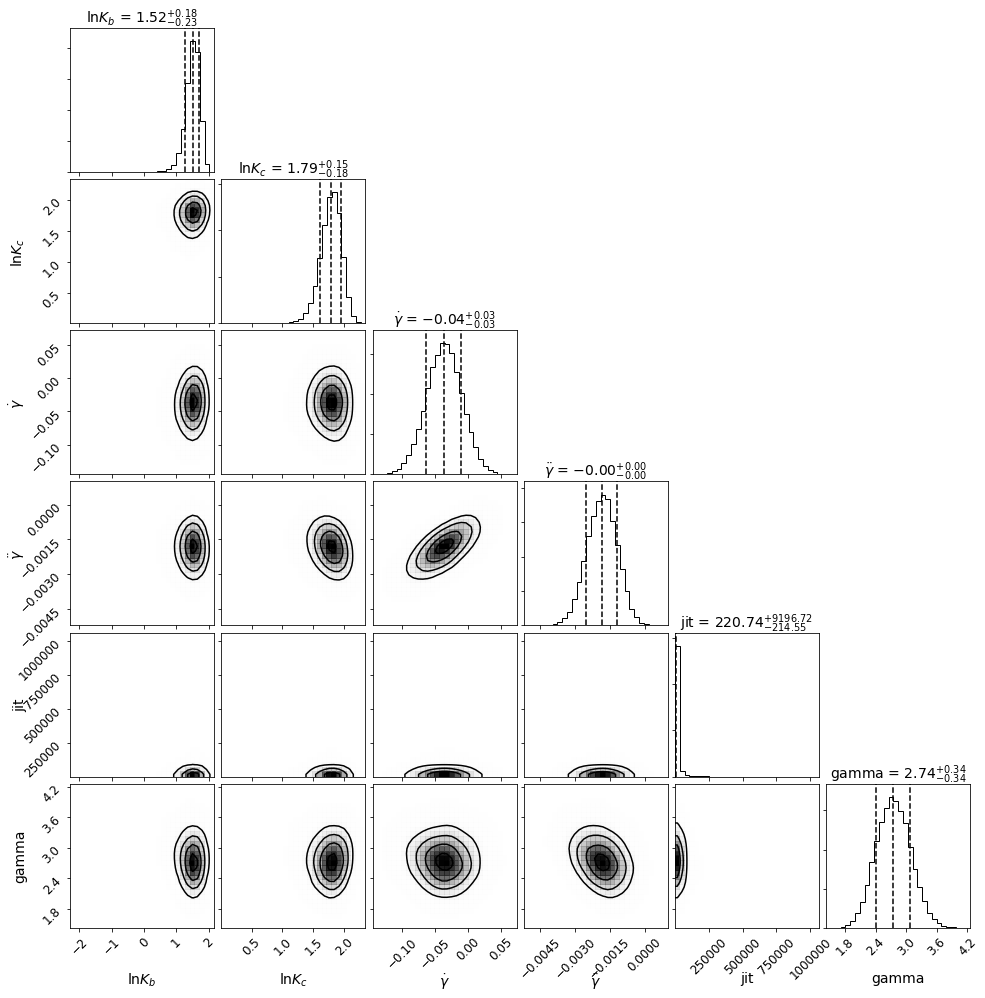

In [39]:
radvel.plotting.corner_plot(post, df)

### Eccentric Fit

Allow ``secosw`` and ``sesinw`` parameters to vary

In [40]:
like.params['secosw1'].vary = True
like.params['sesinw1'].vary = True
like.params['secosw2'].vary = True
like.params['sesinw2'].vary = True

Add an ``EccentricityPrior`` to ensure that eccentricity stays below 1.0. In this example we will also add a Gaussian prior on the jitter (``jit``) parameter with a center at 2.0 m/s and a width of 0.1 m/s.

In [41]:
post = radvel.posterior.Posterior(like)
post.priors += [radvel.prior.EccentricityPrior( 2 )]
post.priors += [radvel.prior.Gaussian( 'jit', np.log(2), np.log(0.1))]

Optimize the parameters by maximizing the likelihood and plot the result

parameter                     value      vary
per1                        20.8853      False
tc1                         2072.79      False
secosw1                   0.0821103       True
sesinw1                    0.402699       True
logk1                       1.15535       True
per2                         42.363      False
tc2                         2082.63      False
secosw2                   -0.187327       True
sesinw2                    -0.71348       True
logk2                       2.25931       True
dvdt                     -0.0189353       True
curv                    -0.00144404       True
jit                         3.46874       True
gamma                       3.46874       True

Priors
------
e1 constrained to be < 0.99
e2 constrained to be < 0.99
Gaussian prior on jit, mu=0.69314718056, sigma=-2.30258509299



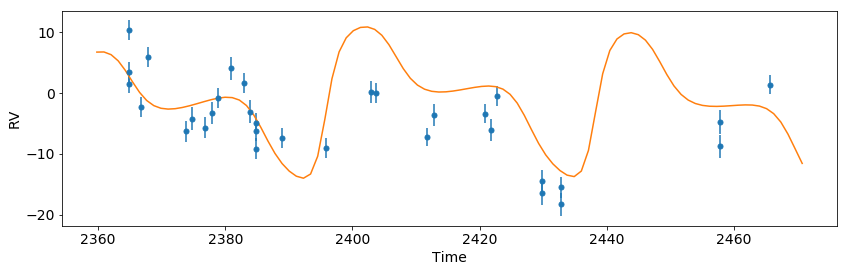

In [42]:
res  = optimize.minimize(
    post.neglogprob_array, 
    post.get_vary_params(), 
    method='Nelder-Mead',)

plot_results(like)
print post

Plot the final solution

(<matplotlib.figure.Figure at 0x111a9a750>,
  <matplotlib.axes._subplots.AxesSubplot at 0x10ec41e50>])

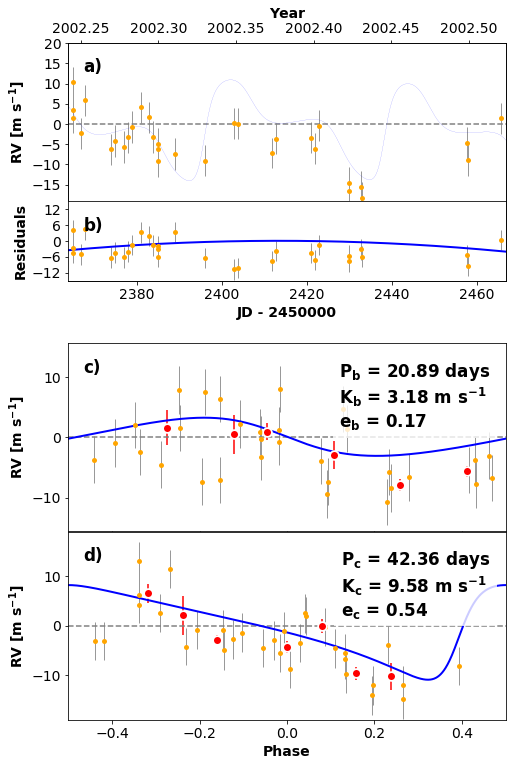

In [43]:
radvel.plotting.rv_multipanel_plot(post)